In [1]:
import pandas as pd
import sympy as sym
import numpy as np
import random 
import statistics as st
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

dataFile = pd.read_csv("sgemm_product.csv")

pd.DataFrame.rename(dataFile,columns={'Run1 (ms)':'Run1','Run2 (ms)':'Run2','Run3 (ms)':'Run3', 'Run4 (ms)':'Run4'},inplace =True)
dataFile['AvgRunTime']=dataFile.apply(lambda row:(row.Run1+row.Run2+row.Run3+row.Run4)/4,axis=1)

dataFile = dataFile.drop(["Run1","Run2","Run3","Run4"], axis=1)



In [2]:
columnList = list(dataFile.columns)
for column in dataFile.columns.difference(['STRM', 'STRN', 'SA', 'SB']):
     dataFile[column] = (dataFile[column]-st.mean(dataFile[column]))/(st.stdev(dataFile[column]))
    # dataFile[column] = (dataFile[column]-min(dataFile[column]))/(max(dataFile[column])-min(dataFile[column]))

train_data, test_data = train_test_split(dataFile, test_size = 0.3, random_state = 1234,shuffle = True)


In [3]:
def createSymbols(n):
    n+=1
    return [sym.symbols('b0:%d'%n)]

def CostFunction(y, x, b) :
    func = b[0]+ np.dot(b[1:],x)-y
    return np.sum(func**2)

def diffCostFunction(sampleSize,y,x,b,indexOfParameter):
    J = 0
    if(indexOfParameter==0):
         J =b[0]+ np.dot(b[1:],x)-y
    else:
        J =np.dot((b[0]+ np.dot(b[1:],x)-y),  x.iloc[indexOfParameter-1])
    
    J = np.sum(J)
    return J*(1/(sampleSize))

def LmDefined(noOfParameters, inputData, sampleSize, lRate, threshold, parametersInput,numberOfIterations):
    
    #Declaration
    newParameters={}
    cfValue=[]
    minAtIndex=-1
    
    #Creating Symbols
    createdSymbols=createSymbols(noOfParameters)
    b = list(createdSymbols[0])
    
    yData = inputData['AvgRunTime']
    xVal = (inputData.loc[:, inputData.columns != 'AvgRunTime']).transpose()
    parameters=dict(zip(b,parametersInput))
    
    #Initialise Cost Function
    cfValue.append(CostFunction(yData , xVal, parametersInput))
    
    for index in range(numberOfIterations) :
        for parameter in parameters :
            newParameters[parameter]=parameters[parameter]-lRate*(diffCostFunction(sampleSize, yData, xVal, list(parameters.values()),list(parameters.keys()).index(parameter)))
        
        newCfValue= CostFunction(yData, xVal, list(newParameters.values()))
        if abs(newCfValue-cfValue[-1]) < threshold :
            if minAtIndex==-1:
                minAtIndex=index   
    
        parameters.update(newParameters)
        cfValue.append(newCfValue)
    if minAtIndex!=-1 :
        print ("min is achieved at "+str(minAtIndex) + " iteration and the squared error is "+str(cfValue[minAtIndex]))
    else:
        print ("squared error is not converging with the given parameters")
    return [cfValue, minAtIndex]

In [4]:
def logitCostFunc(y, x ,b):
    
    func = np.reciprocal(1+np.exp((-1)*(b[0]+ np.dot(b[1:],x))))

    costFuncVal = -1* (np.sum(np.log(func[np.where(y==1)])) + np.sum(np.log(1-func[np.where(y==0)])))
    return costFuncVal/len(y)

def sigmoidFuncVal(y ,x, b, indexOfParameter):
    func = np.reciprocal(1+np.exp((-1)*(b[0]+ np.dot(b[1:],x))))
    J = func -  y
    if(indexOfParameter != 0):
        J =np.dot(func - y,  x.iloc[indexOfParameter-1])
    J = np.sum(J)
    return (J/len(y))

def logitDefined(noOfParameters, inputData, sampleSize, lRate, threshold, parametersInput,numberOfIterations):       
   
    newParameters={}
    cfValue=[]
    minAtIndex=-1
    
    createdSymbols=createSymbols(noOfParameters)
    b = list(createdSymbols[0])
    
    parameters=dict(zip(b,parametersInput))
    parameterKeysList=list(parameters.keys())
   
    medianVal = np.median(inputData['AvgRunTime'])
    y=np.array(inputData['AvgRunTime'])
    y = (y<medianVal).astype(int)
    x =(inputData.iloc[:,inputData.columns != 'AvgRunTime']).transpose()
    
    cfValue.append(logitCostFunc(y, x, list(parameters.values())))

    for index in range(1,numberOfIterations) :
        
        for parameter in parameters :
            indexVal= parameterKeysList.index(parameter)
            newParameters[parameter]=parameters[parameter]-lRate*(sigmoidFuncVal(y, x, list(parameters.values()), indexVal))
      
        newCfValue= logitCostFunc(y, x, list(newParameters.values()))
        if abs(newCfValue-cfValue[-1])<threshold :
            if minAtIndex==-1:
                minAtIndex=index
        
        parameters.update(newParameters)
        cfValue.append(newCfValue)
        
    if minAtIndex!=-1 :
        print ("min is achieved at "+str(minAtIndex) + " iteration and the squared error is "+str(cfValue[minAtIndex]))
    else:
        print ("squared error is not converging with the given parameters")
    return [cfValue, minAtIndex]

min is achieved at 193 iteration and the squared error is 101041.66997619592
min is achieved at 187 iteration and the squared error is 42103.21286365832


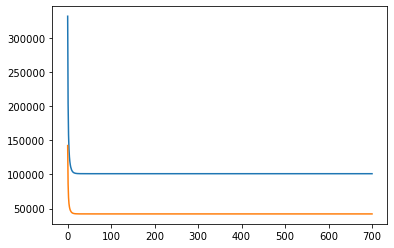

In [6]:
parametersInput = [0.21, 0.25, 0.19, 0.20, 0.22, 0.24, 0.26, 0.18, 0.27, 0.28, 0.29,0.31,0.18, 0.32, 0.20]
plt.plot(LmDefined(len(columnList)-1, train_data[columnList], len(train_data) ,0.25,0.00001,parametersInput,700)[0],label="Train")
plt.plot(LmDefined(len(columnList)-1, test_data[columnList], len(test_data) ,0.25,0.00001,parametersInput,700)[0],label="Test" )


min is achieved at 350 iteration and the squared error is 101041.67402719802
min is achieved at 189 iteration and the squared error is 101041.67186828655
min is achieved at 131 iteration and the squared error is 101041.67117193801


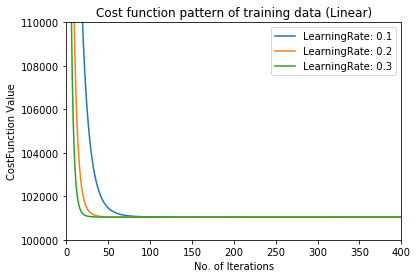

In [7]:
parametersInput = [0.21, 0.25, 0.19, 0.20, 0.22, 0.24, 0.26, 0.18, 0.27, 0.28, 0.29,0.31,0.18, 0.32, 0.20]
plt.ylim(100000, 110000)
plt.xlim(0,400)
plt.title("Cost function pattern of training data (Linear)")
plt.ylabel("CostFunction Value")
plt.xlabel("No. of Iterations")
plt.plot(LmDefined(len(columnList)-1, train_data[columnList], len(train_data) ,0.10,0.0001,parametersInput,700)[0],label="LearningRate: " +str(0.10))
plt.plot(LmDefined(len(columnList)-1, train_data[columnList], len(train_data) ,0.20,0.0001,parametersInput,700)[0],label="LearningRate: " +str(0.20))
plt.plot(LmDefined(len(columnList)-1, train_data[columnList], len(train_data) ,0.30,0.0001,parametersInput,700)[0],label="LearningRate: " +str(0.30))
plt.legend()

min is achieved at 337 iteration and the squared error is 42103.21685004588
min is achieved at 182 iteration and the squared error is 42103.21477147242
min is achieved at 126 iteration and the squared error is 42103.21410259092


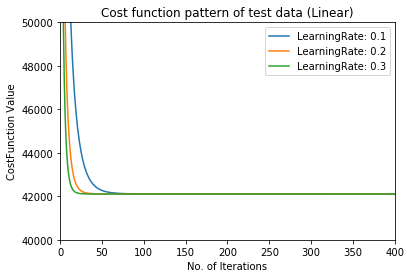

In [8]:
plt.title("Cost function pattern of test data (Linear)")
plt.ylabel("CostFunction Value")
plt.xlabel("No. of Iterations")
plt.ylim(40000 , 50000)
plt.xlim(0,400)
plt.plot(LmDefined(len(columnList)-1, test_data[columnList], len(test_data) ,0.10,0.0001,parametersInput,700)[0],label="LearningRate: " +str(0.10))
plt.plot(LmDefined(len(columnList)-1, test_data[columnList], len(test_data) ,0.20,0.0001,parametersInput,700)[0],label="LearningRate: " +str(0.20))
plt.plot(LmDefined(len(columnList)-1, test_data[columnList], len(test_data) ,0.30,0.0001,parametersInput,700)[0],label="LearningRate: " +str(0.30))
plt.legend()

min is achieved at 178 iteration and the squared error is 0.4870705320680641
min is achieved at 122 iteration and the squared error is 0.4823593947132127
min is achieved at 97 iteration and the squared error is 0.4804387437091006


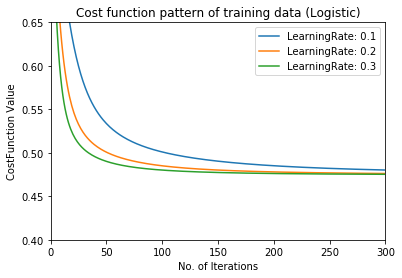

In [9]:
parametersInput = [0.21, 0.25, 0.19, 0.20, 0.22, 0.24, 0.26, 0.18, 0.27, 0.28, 0.29,0.31,0.18, 0.32, 0.20]
plt.title("Cost function pattern of training data (Logistic)")
plt.ylabel("CostFunction Value")
plt.xlabel("No. of Iterations")
plt.ylim(0.40 , 0.65)
plt.xlim(0,300)
plt.plot(logitDefined(len(columnList)-1, train_data[columnList], len(train_data) ,0.10,0.0001,parametersInput,700)[0],label="LearningRate: " +str(0.10))
plt.plot(logitDefined(len(columnList)-1, train_data[columnList], len(train_data) ,0.20,0.0001,parametersInput,700)[0],label="LearningRate: " +str(0.20))
plt.plot(logitDefined(len(columnList)-1, train_data[columnList], len(train_data) ,0.30,0.0001,parametersInput,700)[0],label="LearningRate: " +str(0.30))
plt.legend()

min is achieved at 174 iteration and the squared error is 0.4938246125318921
min is achieved at 119 iteration and the squared error is 0.48928423295596873
min is achieved at 94 iteration and the squared error is 0.48747788766888867


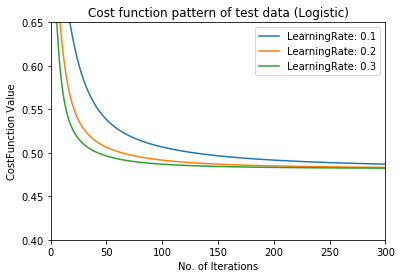

In [10]:
plt.title("Cost function pattern of test data (Logistic)")
plt.ylabel("CostFunction Value")
plt.xlabel("No. of Iterations")
plt.ylim(0.40 , 0.65)
plt.xlim(0,300)
plt.plot(logitDefined(len(columnList)-1, test_data[columnList], len(test_data) ,0.10,0.0001,parametersInput,700)[0],label="LearningRate: " +str(0.10))
plt.plot(logitDefined(len(columnList)-1, test_data[columnList], len(test_data) ,0.20,0.0001,parametersInput,700)[0],label="LearningRate: " +str(0.20))
plt.plot(logitDefined(len(columnList)-1, test_data[columnList], len(test_data) ,0.30,0.0001,parametersInput,700)[0],label="LearningRate: " +str(0.30))
plt.legend()

min is achieved at 131 iteration and the squared error is 101041.67117193801
min is achieved at 99 iteration and the squared error is 101041.68352894069
min is achieved at 72 iteration and the squared error is 101041.78288952919


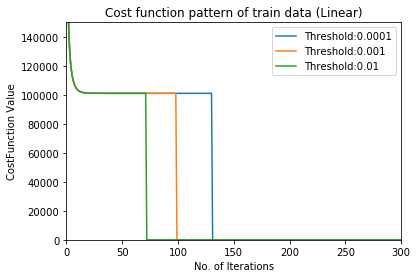

In [11]:
parametersInput = [0.21, 0.25, 0.19, 0.20, 0.22, 0.24, 0.26, 0.18, 0.27, 0.28, 0.29,0.31,0.18, 0.32, 0.20]
plt.title("Cost function pattern of train data (Linear)")
plt.ylabel("CostFunction Value")
plt.xlabel("No. of Iterations")
plt.ylim(0 ,150000)
thresholds = [0.0001,0.001, 0.01]
plt.xlim(0, 300)
for threshold in thresholds:
    result = LmDefined(len(columnList)-1, train_data[columnList], len(train_data) ,0.30, threshold, parametersInput,500)
    for index in range(result[1],500):
        result[0][index] = 0
    plt.plot(result[0],label="Threshold:" +str(threshold))
    plt.legend()


min is achieved at 126 iteration and the squared error is 42103.21410259092
min is achieved at 95 iteration and the squared error is 42103.225943076024
min is achieved at 67 iteration and the squared error is 42103.32711394444


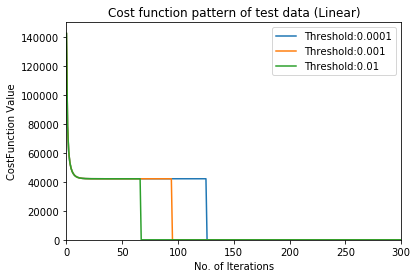

In [12]:
plt.title("Cost function pattern of test data (Linear)")
plt.ylabel("CostFunction Value")
plt.xlabel("No. of Iterations")
plt.ylim(0 ,150000)
thresholds = [0.0001, 0.001, 0.01]
plt.xlim(0, 300)
for threshold in thresholds:
    result = LmDefined(len(columnList)-1, test_data[columnList], len(test_data) ,0.30, threshold, parametersInput,500)
    for index in range(result[1],500):
        result[0][index] = 0
    plt.plot(result[0],label="Threshold:" +str(threshold))
plt.legend()

min is achieved at 97 iteration and the squared error is 0.4804387437091006
min is achieved at 33 iteration and the squared error is 0.5008709217628773
min is achieved at 11 iteration and the squared error is 0.5660125547094573


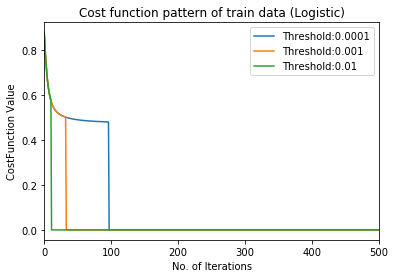

In [13]:
plt.title("Cost function pattern of train data (Logistic)")
plt.ylabel("CostFunction Value")
plt.xlabel("No. of Iterations")
plt.xlim (0, 500)
thresholds = [0.0001, 0.001, 0.01]
for threshold in thresholds:
    result = logitDefined(len(columnList)-1, train_data[columnList], len(train_data) ,0.30,threshold,parametersInput,500)
    for index in range(result[1],500):
        result[0][index] = 0
    plt.plot(result[0],label="Threshold:" +str(threshold))

plt.legend()

min is achieved at 94 iteration and the squared error is 0.48747788766888867
min is achieved at 32 iteration and the squared error is 0.5075054513347862
min is achieved at 11 iteration and the squared error is 0.569882707744424


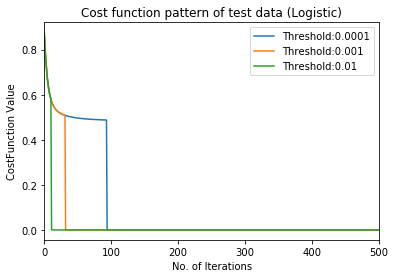

In [14]:
parametersInput = [0.21, 0.25, 0.19, 0.20, 0.22, 0.24, 0.26, 0.18, 0.27, 0.28, 0.29,0.31,0.18, 0.32, 0.20]
plt.title("Cost function pattern of test data (Logistic)")
plt.ylabel("CostFunction Value")
plt.xlabel("No. of Iterations")
plt.xlim (0, 500)
thresholds = [0.0001, 0.001, 0.01]
for threshold in thresholds:
    result = logitDefined(len(columnList)-1, test_data[columnList], len(test_data) ,0.30,threshold,parametersInput,500)
    for index in range(result[1],500):
        result[0][index] = 0
    plt.plot(result[0],label="Threshold:" +str(threshold))

plt.legend()

min is achieved at 131 iteration and the squared error is 101041.67117193801
min is achieved at 126 iteration and the squared error is 42103.21410259092


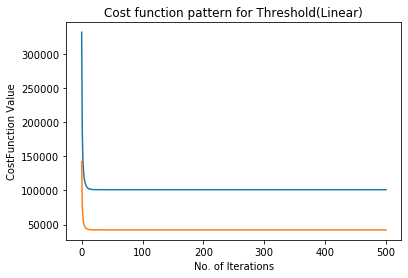

In [15]:
parametersInput = [0.21, 0.25, 0.19, 0.20, 0.22, 0.24, 0.26, 0.18, 0.27, 0.28, 0.29,0.31,0.18, 0.32, 0.20]
plt.title("Cost function pattern for Threshold(Linear)")
plt.ylabel("CostFunction Value")
plt.xlabel("No. of Iterations")
plt.plot(LmDefined(len(columnList)-1, train_data[columnList], len(train_data) ,0.30,0.0001,parametersInput,500)[0],label="Train")
plt.plot(LmDefined(len(columnList)-1, test_data[columnList], len(test_data) ,0.30,0.0001,parametersInput,500)[0],label="Test")


min is achieved at 97 iteration and the squared error is 0.4804387437091006
min is achieved at 94 iteration and the squared error is 0.48747788766888867


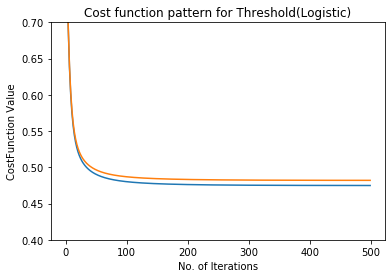

In [16]:
parametersInput = [0.21, 0.25, 0.19, 0.20, 0.22, 0.24, 0.26, 0.18, 0.27, 0.28, 0.29,0.31,0.18, 0.32, 0.20]
plt.title("Cost function pattern for Threshold(Logistic)")
plt.ylabel("CostFunction Value")
plt.xlabel("No. of Iterations")
plt.ylim(0.40,0.70)
plt.plot(logitDefined(len(columnList)-1, train_data[columnList], len(train_data) ,0.30,0.0001,parametersInput,500)[0],label="Train")
plt.plot(logitDefined(len(columnList)-1, test_data[columnList], len(test_data) ,0.30,0.0001,parametersInput,500)[0],label="Test")


min is achieved at 131 iteration and the squared error is 101041.67117193801
min is achieved at 126 iteration and the squared error is 42103.21410259092


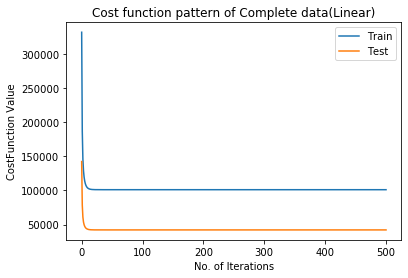

In [17]:
plt.title("Cost function pattern of Complete data(Linear)")
plt.ylabel("CostFunction Value")
plt.xlabel("No. of Iterations")
plt.plot(LmDefined(len(columnList)-1, train_data[columnList], len(train_data) ,0.30,0.0001,parametersInput,500)[0],label="Train")
plt.plot(LmDefined(len(columnList)-1, test_data[columnList], len(test_data) ,0.30,0.0001,parametersInput,500)[0],label="Test")
plt.legend()

['MWG', 'NWG', 'MDIMC', 'MDIMA', 'NDIMB', 'KWI', 'VWM', 'VWN', 'STRN', 'SB']
min is achieved at 118 iteration and the squared error is 119329.64694100169
min is achieved at 114 iteration and the squared error is 49642.82734612157


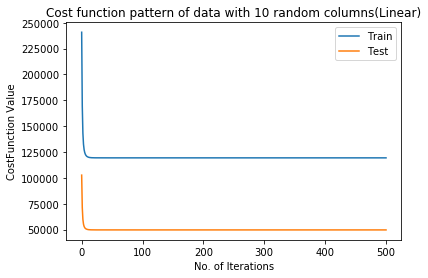

In [18]:
import random as rd
random.seed(15432)
colIndices = list(rd.sample(range(14),10))
colIndices.sort()
colIndices
colList = dataFile.columns
colList = list(colList[colIndices])
print(colList)
colList.append("AvgRunTime")
parametersInputNew = [0.21, 0.25, 0.19, 0.20, 0.22, 0.24, 0.26, 0.18, 0.27, 0.28, 0.29]
plt.title("Cost function pattern of data with 10 random columns(Linear)")
plt.ylabel("CostFunction Value")
plt.xlabel("No. of Iterations")
plt.plot(LmDefined(len(colList)-1, train_data[colList], len(train_data) ,0.30,0.0001,parametersInputNew,500)[0],label="Train")
plt.plot(LmDefined(len(colList)-1, test_data[colList], len(test_data) ,0.30,0.0001,parametersInputNew,500)[0],label="Test")
plt.legend()

min is achieved at 62 iteration and the squared error is 0.533844096583173
min is achieved at 60 iteration and the squared error is 0.5395620957556647


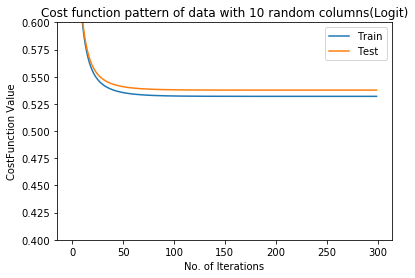

In [19]:
plt.title("Cost function pattern of data with 10 random columns(Logit)")
plt.ylabel("CostFunction Value")
plt.xlabel("No. of Iterations")
plt.ylim(0.40,0.60)
plt.plot(logitDefined(len(colList)-1, train_data[colList], len(train_data) ,0.30,0.0001,parametersInputNew,300)[0],label="Train")
plt.plot(logitDefined(len(colList)-1, test_data[colList], len(test_data) ,0.30,0.0001,parametersInputNew,300)[0],label="Test")
plt.legend()

min is achieved at 97 iteration and the squared error is 0.4804387437091006
min is achieved at 94 iteration and the squared error is 0.48747788766888867


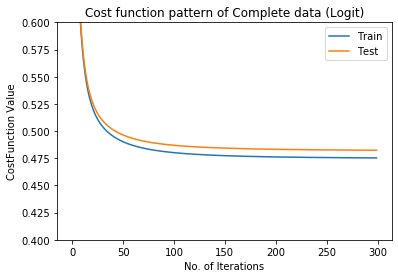

In [20]:
plt.title("Cost function pattern of Complete data (Logit)")
plt.ylabel("CostFunction Value")
plt.xlabel("No. of Iterations")
plt.ylim(0.40,0.60)
plt.plot(logitDefined(len(columnList)-1, train_data[columnList], len(train_data) ,0.30,0.0001,parametersInput,300)[0],label="Train")
plt.plot(logitDefined(len(columnList)-1, test_data[columnList], len(test_data) ,0.30,0.0001,parametersInput,300)[0],label="Test")
plt.legend()

In [21]:
corr = dataFile.corr()
corr.style.background_gradient(cmap='coolwarm')

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,AvgRunTime
MWG,1,0.000599926,0.00929591,0.105791,-0.00859019,0.158772,0.0148979,1.04773e-19,0.353763,-0.000840983,-7.35249e-21,0,0,0,0.35181
NWG,0.000599926,1,0.00929591,-0.00859019,0.105791,0.0148979,0.158772,2.941e-20,-0.000840983,0.353763,1.83812e-21,1.83812e-21,0,0,0.32046
KWG,0.00929591,0.00929591,1,0.148348,0.148348,-0.0345633,-0.0345633,-6.56211e-19,-0.0119861,-0.0119861,6.43342e-21,2.75718e-21,0,0,0.0112296
MDIMC,0.105791,-0.00859019,0.148348,1,-0.209562,0.197433,0.0846055,2.53661e-18,-0.133911,0.0105312,-3.49243e-19,-3.67624e-21,0,0,-0.221097
NDIMC,-0.00859019,0.105791,0.148348,-0.209562,1,0.0846055,0.197433,-7.3525e-20,0.0105312,-0.133911,1.10287e-20,3.67624e-21,0,0,-0.214595
MDIMA,0.158772,0.0148979,-0.0345633,0.197433,0.0846055,1,0.0880962,-1.07898e-18,-0.202712,-0.0190323,5.51436e-21,1.83812e-21,0,0,-0.00703524
NDIMB,0.0148979,0.158772,-0.0345633,0.0846055,0.197433,0.0880962,1,3.09724e-18,-0.0190323,-0.202712,-1.83812e-21,-1.83812e-21,0,0,-0.00870658
KWI,1.04773e-19,2.941e-20,-6.56211e-19,2.53661e-18,-7.3525e-20,-1.07898e-18,3.09724e-18,1,9.40927e-17,-1.4444e-17,0,0,0,0,0.0325709
VWM,0.353763,-0.000840983,-0.0119861,-0.133911,0.0105312,-0.202712,-0.0190323,9.40927e-17,1,0.0011645,-1.19478e-20,-4.5953e-21,0,0,0.164273
VWN,-0.000840983,0.353763,-0.0119861,0.0105312,-0.133911,-0.0190323,-0.202712,-1.4444e-17,0.0011645,1,3.67624e-21,3.67624e-21,0,0,0.144745


['MWG', 'NWG', 'MDIMC', 'NDIMC', 'KWI', 'VWM', 'VWN', 'STRM', 'SA', 'SB', 'AvgRunTime']
min is achieved at 121 iteration and the squared error is 103048.60124190034
min is achieved at 118 iteration and the squared error is 42963.71300305453


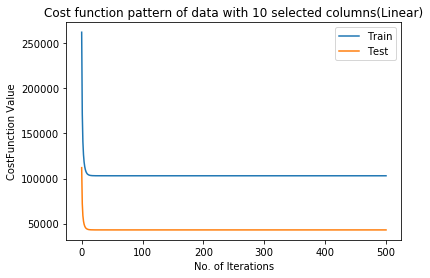

In [22]:
excludeColumns=['KWG', 'MDIMA','NDIMB', 'STRN']
selectedColumns = list(dataFile.columns)
for feature in excludeColumns:
    selectedColumns.remove(feature)
print(selectedColumns)
parametersInputNew = [0.21, 0.25, 0.19, 0.20, 0.22, 0.24, 0.26, 0.18, 0.27, 0.28, 0.29]
plt.title("Cost function pattern of data with 10 selected columns(Linear)")
plt.ylabel("CostFunction Value")
plt.xlabel("No. of Iterations")
plt.plot(LmDefined(len(selectedColumns)-1, train_data[selectedColumns], len(train_data) ,0.30,0.0001,parametersInputNew,500)[0],label="Train")
plt.plot(LmDefined(len(selectedColumns)-1, test_data[selectedColumns], len(test_data) ,0.30,0.0001,parametersInputNew,500)[0],label="Test")
plt.legend()

min is achieved at 96 iteration and the squared error is 0.48286737088234816
min is achieved at 94 iteration and the squared error is 0.4896688569541692


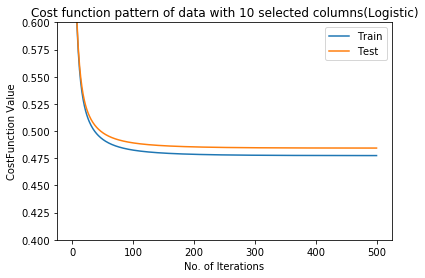

In [23]:
plt.title("Cost function pattern of data with 10 selected columns(Logistic)")
plt.ylabel("CostFunction Value")
plt.xlabel("No. of Iterations")
plt.ylim(0.40,0.60)
plt.plot(logitDefined(len(selectedColumns)-1, train_data[selectedColumns], len(train_data) ,0.30,0.0001,parametersInputNew,500)[0],label="Train")
plt.plot(logitDefined(len(selectedColumns)-1, test_data[selectedColumns], len(test_data) ,0.30,0.0001,parametersInputNew,500)[0],label="Test")
plt.legend()

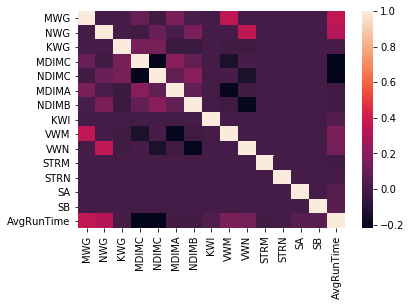

In [24]:
import seaborn as sns
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)